<a href="https://colab.research.google.com/github/Gatwaza/Gatwaza/blob/main/JR_Gatwaza_Summative_Assignment_Model_Training_and_Evaluation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What if you request a bank credits for your agriculture endeavors and later on you notice cultivars are not enough for your specific land parameters and worse case scenario the period for starting to pay back dooesn't equivalent to the yielf is gonna take, uncalculated risks leads to devasted results.
Allow me to take you through the process that could save trouble and reassure your decision making at the same time.

**Import necessary libraries and set up for reproducibility**

In [ ]:
# Install libraries & import, set seeds for reproducibility
!pip install -q pandas matplotlib seaborn scikit-learn tensorflow==2.13.1 joblib

import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Imports ready. TensorFlow version:", tf.__version__)


ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.1
Imports ready. TensorFlow version: 2.19.0


**Load downloaded data from kagglet**

In [ ]:
# Load dataset and inspect accordingly
DATA_PATH = 'hvstat_africa_data_v1.0.csv'
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Upload it and re-run."

df = pd.read_csv(DATA_PATH)
print("Rows, cols:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').T)


Rows, cols: (203125, 16)


,fnid,country,country_code,admin_1,admin_2,product,season_name,planting_year,planting_month,harvest_year,harvest_month,crop_production_system,qc_flag,area,production,yield
0,AO2008A101,Angola,AO,Bengo,none,Banana,Main,2007,10,2008,4,All (PS),0,1364.0,19588.0,14.360704
1,AO2008A101,Angola,AO,Bengo,none,Banana,Main,2008,10,2009,4,All (PS),0,1364.0,20461.0,15.000733
2,AO2008A101,Angola,AO,Bengo,none,Banana,Main,2014,10,2015,4,All (PS),0,8706.0,222044.0,25.504709
3,AO2008A101,Angola,AO,Bengo,none,Banana,Main,2015,10,2016,4,All (PS),0,8706.0,222044.0,25.504709
4,AO2008A101,Angola,AO,Bengo,none,Banana,Main,2016,10,2017,4,All (PS),0,9549.7,233967.0,24.499932


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203125 entries, 0 to 203124
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   fnid                    203125 non-null  object 
 1   country                 203125 non-null  object 
 2   country_code            203125 non-null  object 
 3   admin_1                 203125 non-null  object 
 4   admin_2                 203125 non-null  object 
 5   product                 203125 non-null  object 
 6   season_name             203125 non-null  object 
 7   planting_year           203125 non-null  int64  
 8   planting_month          203125 non-null  int64  
 9   harvest_year            203125 non-null  int64  
 10  harvest_month           203125 non-null  int64  
 11  crop_production_system  203125 non-null  object 
 12  qc_flag                 203125 non-null  int64  
 13  area                    190428 non-null  float64
 14  production          

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fnid,203125,1026,KE2013A112,551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,203125,33,Benin,26770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_code,203125,33,BJ,26770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admin_1,203125,417,Southern,9055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admin_2,203125,707,none,66748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,203125,94,Maize,24313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season_name,203125,33,Main,88059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
planting_year,203125.0,NaN,NaN,NaN,2005.638257,10.613502,1960.0,2000.0,2007.0,2014.0,2024.0
planting_month,203125.0,NaN,NaN,NaN,6.007074,3.11832,1.0,3.0,6.0,9.0,11.0
harvest_year,203125.0,NaN,NaN,NaN,2005.968039,10.66434,1960.0,2000.0,2008.0,2014.0,2024.0


**Perform preprocessing procedures**

In [ ]:
# MAIN - Preprocess, handle missing values, outliers, and engineered features
df_proc = df.copy()

# Drop identifiers
for c in ['fnid','index']:
    if c in df_proc.columns: df_proc.drop(columns=[c], inplace=True)

# Target
TARGET = 'yield'
if TARGET not in df_proc.columns:
    raise KeyError(f"Target '{TARGET}' missing in dataset.")
df_proc.dropna(subset=[TARGET], inplace=True)

# Numeric imputations
for c in ['area','production']:
    if c in df_proc.columns:
        df_proc[c] = df_proc[c].fillna(df_proc[c].median())

# Winsorize numeric features (1-99 percentile)
numeric_cols = [c for c in df_proc.columns if pd.api.types.is_numeric_dtype(df_proc[c]) and c != TARGET]
for c in numeric_cols:
    low, high = df_proc[c].quantile([0.01,0.99])
    df_proc[c] = df_proc[c].clip(low, high)

# Categorical / numeric identification
cat_cols = [c for c in ['country','country_code','admin_1','admin_2','product','season_name','crop_production_system'] if c in df_proc.columns]
num_cols = [c for c in df_proc.columns if c not in cat_cols + [TARGET] and pd.api.types.is_numeric_dtype(df_proc[c])]

# Join keys for APSIM merging
join_keys = [k for k in ['country','product','planting_year','admin_1','season_name'] if k in df_proc.columns]

# Derived features
if 'planting_month' in df_proc.columns and 'harvest_month' in df_proc.columns:
    df_proc['season_length'] = (df_proc['harvest_month'] - df_proc['planting_month']).fillna(0).astype(int)
    num_cols.append('season_length')

if 'production' in df_proc.columns and 'area' in df_proc.columns:
    df_proc['prod_per_area'] = df_proc['production'] / (df_proc['area'] + 1e-6)
    num_cols.append('prod_per_area')

print("Categorical:", cat_cols)
print("Numeric:", num_cols)
print("Join keys:", join_keys)
display(df_proc.head(3))


Categorical: ['country', 'country_code', 'admin_1', 'admin_2', 'product', 'season_name', 'crop_production_system']
Numeric: ['planting_year', 'planting_month', 'harvest_year', 'harvest_month', 'qc_flag', 'area', 'production', 'season_length', 'prod_per_area']
Join keys: ['country', 'product', 'planting_year', 'admin_1', 'season_name']


,country,country_code,admin_1,admin_2,product,season_name,planting_year,planting_month,harvest_year,harvest_month,crop_production_system,qc_flag,area,production,yield,season_length,prod_per_area
0,Angola,AO,Bengo,none,Banana,Main,2007,10,2008,4,All (PS),0,1364.0,19588.0,14.360704,-6,14.360704
1,Angola,AO,Bengo,none,Banana,Main,2008,10,2009,4,All (PS),0,1364.0,20461.0,15.000733,-6,15.000733
2,Angola,AO,Bengo,none,Banana,Main,2014,10,2015,4,All (PS),0,8706.0,222044.0,25.504709,-6,25.504709


**Generate APSIM mechanistic dataset and load them**

In [ ]:
# APSIM simulation & load
APSIM_CSV = 'apsim_simulations.csv'
if os.path.exists(APSIM_CSV):
    apsim_df = pd.read_csv(APSIM_CSV)
    print("Loaded APSIM:", apsim_df.shape)
else:
    print("Generating APSIM-style synthetic dataset...")
    rng = np.random.RandomState(SEED)
    n_sim = 50000
    def sample_vals(col, size):
        vals = df_proc[col].dropna().unique().tolist()
        return list(rng.choice(vals,size=size)) if vals else [None]*size

    sims = []
    for _ in range(n_sim):
        s = {k: sample_vals(k,1)[0] for k in join_keys}
        s['n_rate'] = float(rng.uniform(0,250))
        s['sowing_density'] = float(rng.uniform(50,300))
        s['seasonal_rain'] = float(rng.normal(450,150))
        s['seasonal_temp'] = float(rng.normal(22,3))
        s['radiation'] = float(rng.normal(13.5,2))
        s['soil_organic'] = float(rng.uniform(0.5,4.0))

        # Process-based yield simulation
        cultivar_factor = 0.95 + (sum(map(ord,str(s.get('product','NA')))) % 15)/200.0
        rain_eff = max(0.2,1-0.0008*(450-s['seasonal_rain'])**2)
        temp_eff = max(0.2,1-0.01*(s['seasonal_temp']-20)**2)
        n_eff = 1 - math.exp(-0.02 * s['n_rate'])
        soil_eff = 1 + 0.08*(s['soil_organic'] - 1.5)
        rad_eff = max(0.3,1-0.005*(12-s['radiation'])**2)
        s['sim_yield'] = float(max(0, cultivar_factor*rain_eff*temp_eff*(0.5+0.5*n_eff)*soil_eff*rad_eff))
        s['sim_biomass'] = float(s['sim_yield']*(3.5+rng.normal(0,0.2)))
        s['sim_water_stress'] = float(max(0, min(1, 1 - s['seasonal_rain']/1000.0)))
        sims.append(s)
    apsim_df = pd.DataFrame(sims)
    apsim_df.to_csv(APSIM_CSV, index=False)
    print("Saved synthetic APSIM:", APSIM_CSV, "shape:", apsim_df.shape)

display(apsim_df.head())


Loaded APSIM: (50000, 14)


,country,product,planting_year,admin_1,season_name,n_rate,sowing_density,seasonal_rain,seasonal_temp,radiation,soil_organic,sim_yield,sim_biomass,sim_water_stress
0,Cameroon,Chick Peas,1995,Niger,1st Season,149.664621,89.004660,491.856194,25.031546,12.338244,1.141916,0.139251,0.472751,0.508144
1,Lesotho,Neug,1985,Cross River,Main-off,72.807285,202.963224,385.793090,19.772779,12.093312,3.248116,0.200277,0.615266,0.614207
2,Nigeria,Green Peppers,1976,Bay,Season A,214.985102,220.076885,405.990128,21.910484,13.690252,1.848958,0.188107,0.683381,0.594010
3,Chad,Fava Bean,2008,Kanem,Deyr-off,110.038123,80.509559,369.952679,21.983416,13.041099,2.818828,0.197562,0.706850,0.630047
4,Burkina Faso,Lemon,1983,Gombe,Gu-off,242.396157,243.783206,560.769987,22.514105,13.268703,1.860371,0.192363,0.661687,0.439230


**Merge harvestStat dataset with APSIM generated**

In [ ]:
# Merge on overlapping join keys
merge_on = [k for k in join_keys if k in df_proc.columns and k in apsim_df.columns]
if not merge_on: raise ValueError("No join keys to merge APSIM and HarvestStat.")
merged = df_proc.merge(apsim_df, how='left', on=merge_on, suffixes=('','_apsim'))

# Fill missing APSIM outputs
for col in ['sim_yield','sim_biomass','sim_water_stress']:
    if col in merged.columns:
        merged[col] = merged[col].fillna(merged[col].median())

display(merged[[TARGET,'sim_yield','sim_biomass','sim_water_stress']].head())


,yield,sim_yield,sim_biomass,sim_water_stress
0,14.360704,0.17828,0.665397,0.710597
1,15.000733,0.17828,0.665397,0.710597
2,25.504709,0.17828,0.665397,0.710597
3,25.504709,0.17828,0.665397,0.710597
4,24.499932,0.17828,0.665397,0.710597


**Feature prepping**

In [ ]:
# Standardize numeric features
num_scaler = StandardScaler()
merged[num_cols] = num_scaler.fit_transform(merged[num_cols])

# ML features: frequency encoding for categorical
ml_df = merged.copy()
for c in cat_cols:
    freq = ml_df[c].value_counts(normalize=True)
    ml_df[c+'_freq'] = ml_df[c].map(freq).fillna(0)
ml_feature_cols = num_cols + [c+'_freq' for c in cat_cols]

# DL features: create categorical indices for embeddings
cat_maps = {}
for c in cat_cols:
    vals = merged[c].dropna().unique().tolist()
    cat_maps[c] = {v:i+1 for i,v in enumerate(vals)}  # 0 reserved
    merged[c+'_idx'] = merged[c].map(cat_maps[c]).fillna(0).astype('int32')

dl_num_cols = num_cols


**Split train, val and test**

In [ ]:
# ML splits
X_ml = ml_df[ml_feature_cols].values; y_ml = ml_df[TARGET].values
X_ml_train, X_ml_temp, y_ml_train, y_ml_temp = train_test_split(X_ml, y_ml, test_size=0.3, random_state=SEED)
X_ml_val, X_ml_test, y_ml_val, y_ml_test = train_test_split(X_ml_temp, y_ml_temp, test_size=0.5, random_state=SEED)

# DL splits
X_num = merged[dl_num_cols].values; y_dl = merged[TARGET].values
X_cat = {c: merged[c+'_idx'].values for c in cat_cols}

idx = np.arange(len(merged))
idx_train, idx_temp = train_test_split(idx, test_size=0.3, random_state=SEED)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=SEED)

X_num_train, X_num_val, X_num_test = X_num[idx_train], X_num[idx_val], X_num[idx_test]
y_train, y_val, y_test = y_dl[idx_train], y_dl[idx_val], y_dl[idx_test]
X_cat_train = {c: X_cat[c][idx_train] for c in cat_cols}
X_cat_val = {c: X_cat[c][idx_val] for c in cat_cols}
X_cat_test = {c: X_cat[c][idx_test] for c in cat_cols}


**Experiments set up**

In [ ]:
# Set up an experiment results DataFrame and helper to log experiments
exp_cols = ['Experiment','Model','Hyperparams','TrainSamples','ValSamples','TestSamples','MSE','RMSE','R2','Notes']
exp_table = pd.DataFrame(columns=exp_cols)

def log_experiment(name, model_name, hyperparams, n_train, n_val, n_test, y_true, y_pred, notes=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    row = {
        'Experiment': name, 'Model': model_name, 'Hyperparams': str(hyperparams),
        'TrainSamples': n_train, 'ValSamples': n_val, 'TestSamples': n_test,
        'MSE': mse, 'RMSE': rmse, 'R2': r2, 'Notes': notes
    }
    global exp_table
    exp_table = pd.concat([exp_table, pd.DataFrame([row])], ignore_index=True)
    return row


**Exp 1 - Linear Regression**

In [ ]:
# Cell 9 - Experiment 1: Linear Regression on ML features
lr = LinearRegression()
lr.fit(X_ml_train, y_ml_train)
y_lr = lr.predict(X_ml_test)

log_experiment("Exp 1", "LinearRegression", {"fit_intercept":True}, X_ml_train.shape[0], X_ml_val.shape[0], X_ml_test.shape[0], y_ml_test, y_lr, notes="Baseline linear model on freq-encoded + numeric features")
print(exp_table.tail(1).T)


                                                              0
Experiment                                                Exp 1
Model                                          LinearRegression
Hyperparams                             {'fit_intercept': True}
TrainSamples                                             129801
ValSamples                                                27814
TestSamples                                               27815
MSE                                                    6.243288
RMSE                                                   2.498657
R2                                                     0.969873
Notes         Baseline linear model on freq-encoded + numeri...


/tmp/ipython-input-1114544093.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exp_table = pd.concat([exp_table, pd.DataFrame([row])], ignore_index=True)


**Exp 2 - Ridge**

In [ ]:
# Experiment 2: Ridge
best_alpha = None
best_mse = np.inf
for alpha in [0.1, 1.0, 10.0]:
    r = Ridge(alpha=alpha, random_state=SEED)
    r.fit(X_ml_train, y_ml_train)
    y_pred = r.predict(X_ml_val)
    mse = mean_squared_error(y_ml_val, y_pred)
    if mse < best_mse:
        best_mse = mse; best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=SEED)
ridge.fit(X_ml_train, y_ml_train)
y_ridge = ridge.predict(X_ml_test)
log_experiment("Exp 2", "Ridge", {"alpha":best_alpha}, X_ml_train.shape[0], X_ml_val.shape[0], X_ml_test.shape[0], y_ml_test, y_ridge, notes="L2 regularized linear model; alpha tuned on val")
print(exp_table.tail(1).T)


                                                            1
Experiment                                              Exp 2
Model                                                   Ridge
Hyperparams                                   {'alpha': 10.0}
TrainSamples                                           129801
ValSamples                                              27814
TestSamples                                             27815
MSE                                                  6.243387
RMSE                                                 2.498677
R2                                                   0.969873
Notes         L2 regularized linear model; alpha tuned on val


**Exp 3 - Random Forest**

In [ ]:
# Experiment 3: Random Forest with modest depth to control overfitting
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=SEED, n_jobs=-1)
rf.fit(X_ml_train, y_ml_train)
y_rf = rf.predict(X_ml_test)
log_experiment("Exp 3", "RandomForest", {"n_estimators":200,"max_depth":12}, X_ml_train.shape[0], X_ml_val.shape[0], X_ml_test.shape[0], y_ml_test, y_rf, notes="Tree ensemble captures nonlinearities")
print(exp_table.tail(1).T)


                                                   2
Experiment                                     Exp 3
Model                                   RandomForest
Hyperparams   {'n_estimators': 200, 'max_depth': 12}
TrainSamples                                  129801
ValSamples                                     27814
TestSamples                                    27815
MSE                                         5.713861
RMSE                                        2.390368
R2                                          0.972428
Notes          Tree ensemble captures nonlinearities


**Exp 4 - Gradient Boosting**

In [ ]:
# Experiment 4: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=SEED)
gb.fit(X_ml_train, y_ml_train)
y_gb = gb.predict(X_ml_test)
log_experiment("Exp 4", "GradientBoosting", {"n_estimators":300,"lr":0.05,"max_depth":5}, X_ml_train.shape[0], X_ml_val.shape[0], X_ml_test.shape[0], y_ml_test, y_gb, notes="Boosted trees with moderate depth")
print(exp_table.tail(1).T)


                                                              3
Experiment                                                Exp 4
Model                                          GradientBoosting
Hyperparams   {'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}
TrainSamples                                             129801
ValSamples                                                27814
TestSamples                                               27815
MSE                                                    4.719041
RMSE                                                   2.172335
R2                                                     0.977229
Notes                         Boosted trees with moderate depth


In [ ]:
# Model builder for embedding-based DL networks
def build_embedding_model(cat_cols, cat_maps, num_input_dim, embedding_dim_rule='auto',
                          dense_units=[128,64], dropout_rate=0.3, l2_reg=1e-4, lr=1e-3):
    cat_inputs = []
    cat_embeds = []
    for c in cat_cols:
        vocab = len(cat_maps[c]) + 1
        if embedding_dim_rule == 'auto':
            emb_dim = min(50, max(4, vocab//2))
        else:
            emb_dim = embedding_dim_rule
        inp = Input(shape=(1,), dtype='int32', name=f'{c}_in')
        emb = Embedding(input_dim=vocab, output_dim=emb_dim, name=f'{c}_emb')(inp)
        emb_flat = Flatten()(emb)
        cat_inputs.append(inp)
        cat_embeds.append(emb_flat)
    num_input = Input(shape=(num_input_dim,), dtype='float32', name='num_in')
    if len(cat_embeds) > 0:
        x = Concatenate()(cat_embeds + [num_input])
    else:
        x = num_input
    # dense stack
    for i,units in enumerate(dense_units):
        x = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name=f'dense_{i}')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='linear', name='out')(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

**Exp 5 - DL Baseline**

In [ ]:
# Experiment 5: DL baseline - direct training on HarvestStat (no APSIM pretrain)
dl_model = build_embedding_model(cat_cols, cat_maps, X_num_train.shape[1],
                                 dense_units=[256,128], dropout_rate=0.25, l2_reg=1e-4, lr=1e-3)
dl_model.summary()

# prepare inputs
train_inputs = [X_cat_train[c] for c in cat_cols] + [X_num_train]
val_inputs   = [X_cat_val[c] for c in cat_cols]   + [X_num_val]
test_inputs  = [X_cat_test[c] for c in cat_cols]  + [X_num_test]

early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

hist_dl = dl_model.fit(train_inputs, y_train, validation_data=(val_inputs, y_val), epochs=8, batch_size=256, callbacks=[early, reduce_lr], verbose=1)

y_dl_test = dl_model.predict(test_inputs).ravel()
log_experiment("Exp 5", "DL_baseline", {"units":[256,128],"dropout":0.25,"lr":1e-3}, X_num_train.shape[0], X_num_val.shape[0], X_num_test.shape[0], y_test, y_dl_test, notes="DL with embeddings trained directly on HarvestStat")
print(exp_table.tail(1).T)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ country_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_code_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_1_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_2_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_name_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_production_sy… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_emb         │ (None, 1, 16)     │        528 │ country_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_code_emb    │ (None, 1, 16)     │        528 │ country_code_in[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_1_emb         │ (None, 1, 50)     │     20,500 │ admin_1_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_2_emb         │ (None, 1, 50)     │     33,700 │ admin_2_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_emb         │ (None, 1, 47)     │      4,418 │ product_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_name_emb     │ (None, 1, 17)     │        578 │ season_name_in[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_production_sy… │ (None, 1, 14)     │        392 │ crop_production_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ country_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ country_code_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ admin_1_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ admin_2_emb[0][0

 Total params: 151,525 (591.89 KB)

 Trainable params: 150,757 (588.89 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 75.7151 - mae: 2.4438 - val_loss: 15.6623 - val_mae: 1.2708 - learning_rate: 0.0010
Epoch 2/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 46.1419 - mae: 1.6193 - val_loss: 219.8564 - val_mae: 1.0169 - learning_rate: 0.0010
Epoch 3/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36.1125 - mae: 1.7847
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 36.1082 - mae: 1.7848 - val_loss: 938.3939 - val_mae: 1.3272 - learning_rate: 0.0010
Epoch 4/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 28.7522 - mae: 1.9057 - val_loss: 591.3282 - val_mae: 0.9430 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                                                              4
Experiment                                                Exp 5
Model                

In [ ]:
# DIAGNOSTIC + RUN FINE-TUNE
import numpy as np, os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("=== Files & pretrain confirmation ===")
print("pretrain file exists:", os.path.exists(pre_weights), "size (bytes):", os.path.getsize(pre_weights) if os.path.exists(pre_weights) else None)
# if pre_hist exists, show last val_loss
try:
    print("pretrain history keys:", list(pre_hist.history.keys())[:10])
    print("pretrain last val_loss:", pre_hist.history.get('val_loss')[-1])
except Exception:
    print("pre_hist not found or not populated (ok if pretrain wasn't run in this session).")

# quick weight-norm check for a couple of layers (pre_model vs ft_model)
def layer_norms(model, layer_names):
    out = {}
    for ln in layer_names:
        try:
            layer = model.get_layer(ln)
            w = layer.get_weights()
            if not w:
                out[ln] = "no-weights"
            else:
                # show norms of each weight array
                out[ln] = [np.linalg.norm(arr).item() for arr in w]
        except Exception as e:
            out[ln] = f"missing:{e}"
    return out

print("\nSample weight norms for pre_model (if present):")
try:
    print(layer_norms(pre_model, ['embedding','dense','dense_1'] ))
except Exception as e:
    print("pre_model not available in this scope or missing layers:", e)

print("\nSample weight norms for ft_model (after manual load):")
try:
    print(layer_norms(ft_model, ['country_emb','dense_0','dense_1','out'] ))
except Exception as e:
    print("ft_model missing or layers names differ:", e)

# Input shapes & sizes check (must be non-empty)
print("\n=== Input shapes ===")
try:
    print("X_sim_num shape:", X_sim_num.shape)
except Exception:
    print("X_sim_num not present")
try:
    print("X_num_train shape:", X_num_train.shape)
except Exception:
    print("X_num_train not present")
try:
    print("Train inputs list length:", len(train_inputs))
    print("Each cat input length sample:", [arr.shape for arr in train_inputs[:-1]])
    print("Numeric input shape (train_inputs[-1]):", train_inputs[-1].shape)
except Exception as e:
    print("train_inputs not present or malformed:", e)
try:
    print("y_train length:", len(y_train))
except Exception as e:
    print("y_train missing:", e)

# Show if previously run fine-tune histories exist
print("\nExisting fine-tune history objects:", 'hist_ft1' in globals(), 'hist_ft2' in globals())
if 'hist_ft1' in globals():
    print("hist_ft1 epochs:", len(hist_ft1.history.get('loss',[])))
if 'hist_ft2' in globals():
    print("hist_ft2 epochs:", len(hist_ft2.history.get('loss',[])))

# Print trainable layers summary
print("\n=== Model trainable layers summary ===")
total_trainable = 0
for i,l in enumerate(ft_model.layers):
    print(i, l.name, l.__class__.__name__, "trainable=", l.trainable, "weights_count=", len(l.get_weights()))
    if l.trainable:
        total_trainable += sum([np.prod(w.shape) for w in l.get_weights()]) if l.get_weights() else 0
print("Approx total trainable parameters (count):", total_trainable)

# If you want to (re)run fine-tune now, do the two-phase approach used earlier.
# Ensure train_inputs, val_inputs, y_train, y_val exist and are not empty.
assert len(train_inputs) > 0 and len(val_inputs) > 0 and len(y_train) > 0, "train/val inputs or y missing/empty."

# Phase 1: freeze embeddings, train head (6 epochs max)
for layer in ft_model.layers:
    if 'emb' in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True

ft_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
print("\nStarting fine-tune phase 1 (embeddings frozen) - up to 6 epochs")
hist_ft1 = ft_model.fit(train_inputs, y_train, validation_data=(val_inputs, y_val),
                        epochs=6, batch_size=256, callbacks=[es], verbose=1)

# Phase 2: unfreeze all, fine-tune more (4 epochs max)
for layer in ft_model.layers:
    layer.trainable = True
ft_model.compile(optimizer=Adam(learning_rate=5e-5), loss='mse', metrics=['mae'])
es2 = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
print("\nStarting fine-tune phase 2 (all layers trainable) - up to 4 epochs")
hist_ft2 = ft_model.fit(train_inputs, y_train, validation_data=(val_inputs, y_val),
                        epochs=4, batch_size=256, callbacks=[es2], verbose=1)

# Summarize results
print("\nFine-tune completed. Summary:")
print("Phase1 epochs:", len(hist_ft1.history.get('loss',[])), "last val_loss:", hist_ft1.history.get('val_loss')[-1])
print("Phase2 epochs:", len(hist_ft2.history.get('loss',[])), "last val_loss:", hist_ft2.history.get('val_loss')[-1])

# Evaluate on test and log experiment (optional)
y_ft_test = ft_model.predict(test_inputs).ravel()
print("Test RMSE:", np.sqrt(np.mean((y_test - y_ft_test)**2)))


=== Files & pretrain confirmation ===
pretrain file exists: True size (bytes): 1893128
pretrain history keys: ['loss', 'mae', 'val_loss', 'val_mae']
pretrain last val_loss: 0.05684502422809601

Sample weight norms for pre_model (if present):
{'embedding': "missing:No such layer: embedding. Existing layers are: ['country_in', 'country_code_in', 'admin_1_in', 'admin_2_in', 'product_in', 'season_name_in', 'crop_production_system_in', 'country_emb', 'country_code_emb', 'admin_1_emb', 'admin_2_emb', 'product_emb', 'season_name_emb', 'crop_production_system_emb', 'flatten_105', 'flatten_106', 'flatten_107', 'flatten_108', 'flatten_109', 'flatten_110', 'flatten_111', 'num_in', 'concatenate_15', 'dense_0', 'batch_normalization_30', 'dropout_30', 'dense_1', 'batch_normalization_31', 'dropout_31', 'out'].", 'dense': "missing:No such layer: dense. Existing layers are: ['country_in', 'country_code_in', 'admin_1_in', 'admin_2_in', 'product_in', 'season_name_in', 'crop_production_system_in', 'countr

In [ ]:
# APSIM pretrain -> fine-tune (fixed & robust)
import h5py, numpy as np, os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Paths
pre_weights = 'apsim_pretrain.weights.h5'

# 1) Build sim numeric matrix aligned to dl_num_cols (order & length)
# For each numeric column in dl_num_cols, pull from sim_df if present, else use merged column median
sim_df = apsim_df.copy().dropna(subset=join_keys)
aligned_sim_cols = []
for c in dl_num_cols:
    if c in sim_df.columns:
        aligned_sim_cols.append(sim_df[c].fillna(0).values.astype(float))
    else:
        # fallback: fill with median from merged (if available) else zeros
        if c in merged.columns:
            med = merged[c].median()
            aligned_sim_cols.append(np.full(len(sim_df), med, dtype=float))
        else:
            aligned_sim_cols.append(np.zeros(len(sim_df), dtype=float))

# stack into (n_sim, num_dim)
X_sim_num_aligned = np.vstack(aligned_sim_cols).T if len(aligned_sim_cols) > 0 else np.zeros((len(sim_df), 0))
print("X_sim_num_aligned.shape:", X_sim_num_aligned.shape, "expected numeric dim:", len(dl_num_cols))

# 2) Use the same numeric scaler used on merged numeric features (num_scaler) so scale spaces align
# (num_scaler was fit in CELL 6 on merged[num_cols])
if 'num_scaler' not in globals():
    num_scaler = StandardScaler().fit(merged[dl_num_cols].values)  # fallback
X_sim_num = num_scaler.transform(X_sim_num_aligned)

# 3) Standardize target using real target scaler (fit on y_train)
y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
y_sim_s = y_scaler.transform(sim_df['sim_yield'].values.reshape(-1,1)).ravel()

# 4) Build pretrain model with numeric input dim matching dl_num_cols length
pre_model = build_embedding_model(cat_cols, cat_maps, num_input_dim=X_num_train.shape[1],
                                  dense_units=[256,128], dropout_rate=0.25, l2_reg=1e-4, lr=1e-3)
pre_model.summary()

# 5) Prepare sim categorical arrays aligned to cat_cols
X_sim_cat = [sim_df.get(c, pd.Series([None]*len(sim_df))).map(cat_maps[c]).fillna(0).astype('int32').values for c in cat_cols]

# 6) Pretrain on scaled sim targets (note: epochs <= 8 to follow constraint)
pre_hist = pre_model.fit(X_sim_cat + [X_sim_num], y_sim_s, validation_split=0.1,
                         epochs=8, batch_size=512,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                         verbose=1)

# 7) Save pretrain weights (HDF5 .weights.h5)
pre_model.save_weights(pre_weights)
print("Saved pretrain weights to", pre_weights, "size bytes:", os.path.getsize(pre_weights))

# Robust HDF5 loader (works for 'model_weights' or 'layers' topologies)
# This loader will be used to import weights into ft_model without relying on deprecated kwargs.
def _extract_weight_arrays(fileobj, group):
    weight_names = group.attrs.get('weight_names')
    arrays = []
    if weight_names is not None and len(weight_names) > 0:
        for wn in weight_names:
            wn_str = wn.decode() if isinstance(wn, (bytes,bytearray)) else wn
            if wn_str in fileobj:
                arrays.append(np.array(fileobj[wn_str])); continue
            simple = wn_str.split('/')[-1]
            if simple in group:
                arrays.append(np.array(group[simple])); continue
            # search nested
            found = None
            for k,v in group.items():
                if isinstance(v, h5py.Dataset) and (k == simple or simple in k):
                    found = v; break
            if found is not None:
                arrays.append(np.array(found))
            else:
                raise KeyError(f"Dataset {wn_str} not found under group {group.name}")
        return arrays
    # fallback
    for k,item in group.items():
        if isinstance(item, h5py.Dataset):
            arrays.append(np.array(item))
        elif isinstance(item, h5py.Group):
            for kk,sub in item.items():
                if isinstance(sub, h5py.Dataset):
                    arrays.append(np.array(sub))
    return arrays

def load_and_adapt_h5_weights_by_name(model, h5path, skip_mismatch=True, verbose=True):
    if not os.path.exists(h5path):
        raise FileNotFoundError(h5path)
    with h5py.File(h5path,'r') as f:
        if 'model_weights' in f:
            root = f['model_weights']
        elif 'layers' in f:
            root = f['layers']
        else:
            root = f

        # metadata
        groups_meta = {}
        name_to_key = {}
        for key, grp in root.items():
            attrs_name = None
            class_name = None
            try:
                attrs_name = grp.attrs.get('name')
                class_name = grp.attrs.get('class_name')
                if isinstance(attrs_name, (bytes,bytearray)):
                    attrs_name = attrs_name.decode()
                if isinstance(class_name, (bytes,bytearray)):
                    class_name = class_name.decode()
            except Exception:
                pass
            groups_meta[key] = {'attrs_name': attrs_name, 'class_name': class_name}
            if attrs_name:
                name_to_key[attrs_name] = key

        used_keys = set()
        for layer in model.layers:
            layer_name = layer.name
            layer_class = layer.__class__.__name__
            assigned = False
            grp = None

            if layer_name in root:
                grp = root[layer_name]; used_keys.add(layer_name); assigned = True
            elif layer_name in name_to_key:
                k = name_to_key[layer_name]; grp = root[k]; used_keys.add(k); assigned = True
            else:
                # class-based candidate selection
                candidates = []
                for k,meta in groups_meta.items():
                    if meta.get('class_name') and meta['class_name'].lower() == layer_class.lower():
                        candidates.append(k)
                if not candidates:
                    for k in root.keys():
                        if layer_class.lower() in k.lower():
                            candidates.append(k)
                chosen = None
                for k in candidates:
                    if k not in used_keys:
                        chosen = k; break
                if chosen:
                    grp = root[chosen]; used_keys.add(chosen); assigned = True

            if not assigned:
                if verbose:
                    print(f"[skip - no match] layer '{layer_name}' ({layer_class})")
                continue

            # extract saved arrays
            try:
                saved = _extract_weight_arrays(f, grp)
            except Exception as e:
                if verbose:
                    print(f"[error reading group for '{layer_name}']: {e}")
                if not skip_mismatch:
                    raise
                else:
                    continue

            # attempt to set weights if compatible, otherwise adapt
            expected = layer.get_weights()
            if len(expected) == 0:
                if verbose:
                    print(f"[skip] layer '{layer_name}' has no weights to set")
                continue

            # quick adapt logic: try to match shapes; pad/truncate where reasonable
            adapted = []
            for i, exp_arr in enumerate(expected):
                if i < len(saved):
                    sv = saved[i]
                    if sv.shape == exp_arr.shape:
                        adapted.append(sv)
                        continue
                    # 1D bias case
                    if sv.ndim == 1 and exp_arr.ndim == 1:
                        if sv.shape[0] < exp_arr.shape[0]:
                            pad = np.random.normal(scale=1e-3, size=(exp_arr.shape[0]-sv.shape[0],)).astype(sv.dtype)
                            adapted.append(np.concatenate([sv, pad], axis=0))
                        else:
                            adapted.append(sv[:exp_arr.shape[0]])
                        continue
                    # 2D kernel case (pad/trim rows if second dim matches)
                    if sv.ndim == 2 and exp_arr.ndim == 2 and sv.shape[1] == exp_arr.shape[1]:
                        if sv.shape[0] < exp_arr.shape[0]:
                            pad = np.random.normal(scale=1e-3, size=(exp_arr.shape[0]-sv.shape[0], sv.shape[1])).astype(sv.dtype)
                            adapted.append(np.vstack([sv, pad]))
                        else:
                            adapted.append(sv[:exp_arr.shape[0], :])
                        continue
                    # fallback: reshape if total size matches
                    if sv.size == exp_arr.size:
                        try:
                            adapted.append(sv.reshape(exp_arr.shape))
                            continue
                        except Exception:
                            pass
                    # final fallback: init small-random array
                    adapted.append(np.random.normal(scale=1e-3, size=exp_arr.shape).astype(exp_arr.dtype))
                else:
                    adapted.append(np.random.normal(scale=1e-3, size=exp_arr.shape).astype(exp_arr.dtype))

            try:
                layer.set_weights(adapted)
                if verbose:
                    print(f"[loaded] layer '{layer_name}' from group '{grp.name}' (arrays={len(adapted)})")
            except Exception as e:
                if skip_mismatch:
                    if verbose:
                        print(f"[skipped-mismatch] layer '{layer_name}' -> {e}")
                    continue
                else:
                    raise RuntimeError(f"Failed to set_weights for {layer_name}: {e}")

    if verbose:
        print("Finished adaptive HDF5-by-name loading.")

# 8) Build fine-tune model with same numeric dim and load weights robustly
ft_model = build_embedding_model(cat_cols, cat_maps, num_input_dim=X_num_train.shape[1],
                                 dense_units=[256,128], dropout_rate=0.25, l2_reg=1e-4, lr=1e-4)

# Use robust loader to import weights (no by_name kwarg)
load_and_adapt_h5_weights_by_name(ft_model, pre_weights, skip_mismatch=True, verbose=True)
print("Pretrained weights loaded (adaptive loader).")

# 9) Prepare scaled real targets for fine-tune
y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()
y_val_s   = y_scaler.transform(y_val.reshape(-1,1)).ravel()

# 10) Freeze embeddings first, compile and run phase 1 (<=6 epochs)
for layer in ft_model.layers:
    if 'emb' in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True
ft_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
hist_ft1 = ft_model.fit(train_inputs, y_train_s, validation_data=(val_inputs, y_val_s),
                        epochs=6, batch_size=256, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=1)

# 11) Unfreeze and fine-tune phase 2 (<=4 epochs)
for layer in ft_model.layers:
    layer.trainable = True
ft_model.compile(optimizer=Adam(learning_rate=5e-5), loss='mse', metrics=['mae'])
hist_ft2 = ft_model.fit(train_inputs, y_train_s, validation_data=(val_inputs, y_val_s),
                        epochs=4, batch_size=256, callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)], verbose=1)

# 12) Predict on test, inverse-transform to original units and log
y_ft_test_s = ft_model.predict(test_inputs).ravel()
y_ft_test = y_scaler.inverse_transform(y_ft_test_s.reshape(-1,1)).ravel()

log_experiment("Exp 6", "DL_APSIM_pretrain_finetune",
               {"pretrain_epochs":len(pre_hist.history.get('loss',[])),"ft_epochs":[len(hist_ft1.history.get('loss',[])), len(hist_ft2.history.get('loss',[]))]},
               X_num_train.shape[0], X_num_val.shape[0], X_num_test.shape[0],
               y_test, y_ft_test, notes="Pretrained on APSIM sims (scaled targets); then fine-tuned on HarvestStat (targets inverse-transformed for logging)")
print(exp_table.tail(1).T)

X_sim_num_aligned.shape: (50000, 9) expected numeric dim: 9


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ country_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_code_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_1_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_2_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_name_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_production_sy… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_emb         │ (None, 1, 16)     │        528 │ country_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_code_emb    │ (None, 1, 16)     │        528 │ country_code_in[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_1_emb         │ (None, 1, 50)     │     20,500 │ admin_1_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_2_emb         │ (None, 1, 50)     │     33,700 │ admin_2_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_emb         │ (None, 1, 47)     │      4,418 │ product_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_name_emb     │ (None, 1, 17)     │        578 │ season_name_in[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_production_sy… │ (None, 1, 14)     │        392 │ crop_production_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 16)        │          0 │ country_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 16)        │          0 │ country_code_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 50)        │          0 │ admin_1_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 50)        │          0 │ admin_2_emb[0][0

 Total params: 151,525 (591.89 KB)

 Trainable params: 150,757 (588.89 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.1581 - mae: 0.7761 - val_loss: 1.1738 - val_mae: 1.0726
Epoch 2/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3651 - mae: 0.4371 - val_loss: 0.0811 - val_mae: 0.2430
Epoch 3/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2088 - mae: 0.3235 - val_loss: 0.0210 - val_mae: 0.0455
Epoch 4/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1218 - mae: 0.2402 - val_loss: 0.1560 - val_mae: 0.3504
Epoch 5/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0705 - mae: 0.1719 - val_loss: 0.0347 - val_mae: 0.1207
Epoch 6/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0438 - mae: 0.1225 - val_loss: 0.3820 - val_mae: 0.5891
Saved pretrain weights to apsim_pretrain.weights.h5 size bytes: 1902344
[skip - no match] layer 'country_in' (InputLayer)
[skip - no match] layer 'country_code_in' (InputLayer)
[skip - no match] layer 'admin_1_in' (InputLayer)
[skip - no match] layer 'admin_2_in' (InputLayer)
[skip - no match] layer 'pr

In [ ]:
# APSIM-as-feature experiment (uses merged dataset features)
# model_ap_feat uses the merged numeric features (num_scaler already applied in CELL 6)
model_ap_feat = build_embedding_model(cat_cols, cat_maps, X_num_train.shape[1],
                                     dense_units=[128,64], dropout_rate=0.35, l2_reg=1e-3, lr=5e-4)
model_ap_feat.summary()

hist_ap_feat = model_ap_feat.fit(train_inputs, y_train, validation_data=(val_inputs, y_val),
                                 epochs=10, batch_size=256,
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)],
                                 verbose=1)

y_apfeat_test = model_ap_feat.predict(test_inputs).ravel()
log_experiment("Exp 7", "DL_APSIM_feature", {"units":[128,64],"dropout":0.35,"l2":1e-3},
               X_num_train.shape[0], X_num_val.shape[0], X_num_test.shape[0], y_test, y_apfeat_test,
               notes="APSIM outputs provided as features; strong reg applied")
print(exp_table.tail(1).T)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ country_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_code_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_1_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_2_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_name_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_production_sy… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_emb         │ (None, 1, 16)     │        528 │ country_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_code_emb    │ (None, 1, 16)     │        528 │ country_code_in[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_1_emb         │ (None, 1, 50)     │     20,500 │ admin_1_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ admin_2_emb         │ (None, 1, 50)     │     33,700 │ admin_2_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_emb         │ (None, 1, 47)     │      4,418 │ product_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_name_emb     │ (None, 1, 17)     │        578 │ season_name_in[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_production_sy… │ (None, 1, 14)     │        392 │ crop_production_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 16)        │          0 │ country_emb[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 16)        │          0 │ country_code_emb… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 50)        │          0 │ admin_1_emb[0][0

 Total params: 97,893 (382.39 KB)

 Trainable params: 97,509 (380.89 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 96.8353 - mae: 3.1453 - val_loss: 15.1848 - val_mae: 2.1351 - learning_rate: 5.0000e-04
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 62.6218 - mae: 1.7415 - val_loss: 23.1494 - val_mae: 1.1876 - learning_rate: 5.0000e-04
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 59.2391 - mae: 1.7565 - val_loss: 57.7884 - val_mae: 1.1400 - learning_rate: 5.0000e-04
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 53.1354 - mae: 1.8378 - val_loss: 67.9036 - val_mae: 1.1833 - learning_rate: 2.5000e-04
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                                                              6
Experiment                                                Exp 7
Model                                          DL_APSIM_feature
Hyperparams   {'units': [128, 64], 'dropout': 0.35, 'l2': 0....
TrainSamples                                             129801
ValSamples                                     

In [ ]:
# PCA experiment (keeps parity with previous cells)
pca_n = 0.95  # keep 95% variance (or you may set an integer)
pca = PCA(n_components=pca_n, svd_solver='full')
pca.fit(X_num_train)
X_num_train_p = pca.transform(X_num_train)
X_num_val_p = pca.transform(X_num_val)
X_num_test_p = pca.transform(X_num_test)

model_pca = build_embedding_model(cat_cols, cat_maps, X_num_train_p.shape[1], dense_units=[128,64], dropout_rate=0.3, l2_reg=1e-4, lr=1e-3)
hist_pca = model_pca.fit([X_cat_train[c] for c in cat_cols] + [X_num_train_p], y_train, validation_data=([X_cat_val[c] for c in cat_cols] + [X_num_val_p], y_val),
                         epochs=8, batch_size=256, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=1)
y_pca_test = model_pca.predict([X_cat_test[c] for c in cat_cols] + [X_num_test_p]).ravel()
log_experiment("Exp 8", "DL_PCA_numeric", {"pca_var":pca_n,"units":[128,64]}, X_num_train.shape[0], X_num_val.shape[0], X_num_test.shape[0], y_test, y_pca_test, notes="PCA on numeric features before training")
print(exp_table.tail(1).T)

Epoch 1/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 91.8286 - mae: 2.6562 - val_loss: 8.7022 - val_mae: 1.1890
Epoch 2/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 60.2066 - mae: 1.6016 - val_loss: 129.0104 - val_mae: 0.8609
Epoch 3/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 52.6813 - mae: 1.7439 - val_loss: 202.0022 - val_mae: 1.0762
Epoch 4/8
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 44.7877 - mae: 1.9386 - val_loss: 872.9600 - val_mae: 1.2850
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                                                    7
Experiment                                      Exp 8
Model                                  DL_PCA_numeric
Hyperparams     {'pca_var': 0.95, 'units': [128, 64]}
TrainSamples                                   129801
ValSamples                                      27814
TestSamples                                     27815
MSE                                         11.266303
RMSE                                         3.

,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth
2,Exp 3,RandomForest,"{'n_estimators': 200, 'max_depth': 12}",129801,27814,27815,5.713861,2.390368,0.972428,Tree ensemble captures nonlinearities
0,Exp 1,LinearRegression,{'fit_intercept': True},129801,27814,27815,6.243288,2.498657,0.969873,Baseline linear model on freq-encoded + numeri...
1,Exp 2,Ridge,{'alpha': 10.0},129801,27814,27815,6.243387,2.498677,0.969873,L2 regularized linear model; alpha tuned on val
7,Exp 8,DL_PCA_numeric,"{'pca_var': 0.95, 'units': [128, 64]}",129801,27814,27815,11.266303,3.356531,0.945635,PCA on numeric features before training
6,Exp 7,DL_APSIM_feature,"{'units': [128, 64], 'dropout': 0.35, 'l2': 0....",129801,27814,27815,18.246439,4.271585,0.911953,APSIM outputs provided as features; strong reg...
4,Exp 5,DL_baseline,"{'units': [256, 128], 'dropout': 0.25, 'lr': 0...",129801,27814,27815,20.682002,4.547747,0.900200,DL with embeddings trained directly on Harvest...
5,Exp 6,DL_APSIM_pretrain_finetune,"{'pretrain_epochs': 6, 'ft_epochs': [4, 3]}",129801,27814,27815,54.408063,7.376182,0.737457,Pretrained on APSIM sims (scaled targets); the...


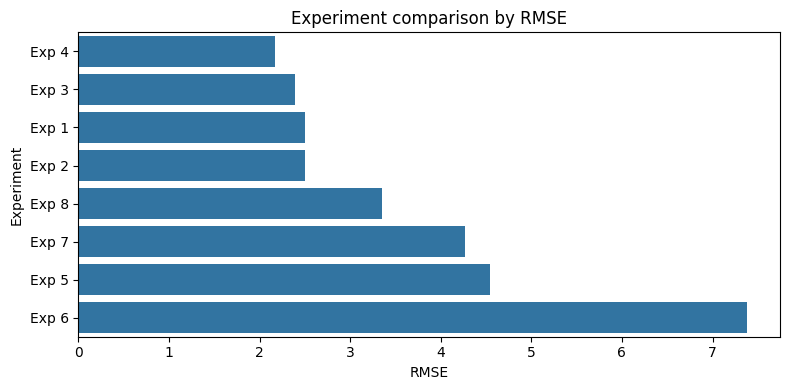

Best experiment: Exp 4 GradientBoosting RMSE: 2.172335269436767


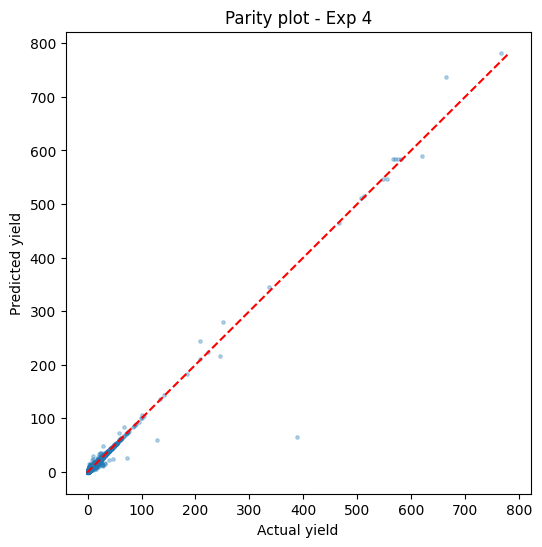

In [ ]:
# Table and comparative plots
display(exp_table.sort_values('RMSE'))

plt.figure(figsize=(8,4))
sns.barplot(data=exp_table.sort_values('RMSE'), x='RMSE', y='Experiment')
plt.title('Experiment comparison by RMSE')
plt.xlabel('RMSE')
plt.tight_layout()
plt.show()

# Parity plot for the best experiment (by RMSE)
best_idx = exp_table['RMSE'].astype(float).idxmin()
best_row = exp_table.loc[best_idx]
print("Best experiment:", best_row['Experiment'], best_row['Model'], "RMSE:", best_row['RMSE'])

pred_map = {
    'Exp 1': y_lr, 'Exp 2': y_ridge, 'Exp 3': y_rf, 'Exp 4': y_gb,
    'Exp 5': y_dl_test if 'y_dl_test' in globals() else None,
    'Exp 6': y_ft_test if 'y_ft_test' in globals() else None,
    'Exp 7': y_apfeat_test if 'y_apfeat_test' in globals() else None,
    'Exp 8': y_pca_test if 'y_pca_test' in globals() else None
}
best_pred = pred_map.get(best_row['Experiment'])
if best_pred is not None:
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, best_pred, alpha=0.3, s=6)
    mn, mx = min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.xlabel('Actual yield')
    plt.ylabel('Predicted yield')
    plt.title(f'Parity plot - {best_row["Experiment"]}')
    plt.show()
else:
    print("No stored predictions for parity plot of best experiment (maybe best is classical ML).")


In [ ]:
# Artifact saving
import os, shutil, joblib
from pathlib import Path
from sklearn.preprocessing import StandardScaler

OUT_DIR = '/mnt/data/models'
os.makedirs(OUT_DIR, exist_ok=True)

def safe_joblib_dump(obj, path):
    try:
        joblib.dump(obj, path)
        print(f"Saved: {path}")
    except Exception as e:
        print(f"[skip/save-error] Could not save {path}: {e}")

def safe_model_save(model, path_base):
    """Save model in native Keras (.keras) and attempt legacy HDF5 if requested."""
    try:
        # native Keras format (recommended)
        model.save(path_base + '.keras')
        print(f"Saved model (native Keras): {path_base + '.keras'}")
    except Exception as e:
        print(f"[warn] native .keras save failed for {path_base}: {e}")
    # also try legacy HDF5 for compatibility (non-fatal warning often emitted)
    try:
        model.save(path_base + '.h5')
        print(f"Saved model (HDF5 legacy): {path_base + '.h5'}")
    except Exception as e:
        print(f"[warn] HDF5 .h5 save failed for {path_base}: {e}")

# 1) Classical models (joblib)
for name, mdl in [('exp1_linear_reg', globals().get('lr', None)),
                  ('exp2_ridge', globals().get('ridge', None)),
                  ('exp3_rf', globals().get('rf', None)),
                  ('exp4_gb', globals().get('gb', None))]:
    if mdl is not None:
        safe_joblib_dump(mdl, os.path.join(OUT_DIR, f'{name}.joblib'))
    else:
        print(f"[skip] {name} not found in session; skipping.")

# 2) Deep models (save as .keras and try .h5)
if 'dl_model' in globals() and dl_model is not None:
    safe_model_save(dl_model, os.path.join(OUT_DIR, 'exp5_dl_baseline'))
else:
    print("[skip] dl_model not present; skipping exp5 save.")

# pretrain weights file (HDF5) - copy to models folder if present
pre_weights_src = globals().get('pre_weights', 'apsim_pretrain.weights.h5')
if os.path.exists(pre_weights_src):
    try:
        shutil.copy(pre_weights_src, os.path.join(OUT_DIR, os.path.basename(pre_weights_src)))
        print(f"Copied pretrain weights to {os.path.join(OUT_DIR, os.path.basename(pre_weights_src))}")
    except Exception as e:
        print(f"[warn] could not copy pretrain weights: {e}")
else:
    print(f"[skip] pretrain weights file not found at {pre_weights_src}; skipping copy.")

# If pre_model exists, save full pre_model (both .keras and .h5)
if 'pre_model' in globals() and pre_model is not None:
    safe_model_save(pre_model, os.path.join(OUT_DIR, 'exp6_pretrained_apsim_full'))
else:
    print("[note] pre_model not in session (maybe only weights file exists).")

# Fine-tuned model
if 'ft_model' in globals() and ft_model is not None:
    safe_model_save(ft_model, os.path.join(OUT_DIR, 'exp6_finetuned'))
else:
    print("[skip] ft_model not present; skipping exp6 finetuned save.")

# APSIM-as-feature model
if 'model_ap_feat' in globals() and model_ap_feat is not None:
    safe_model_save(model_ap_feat, os.path.join(OUT_DIR, 'exp7_apfeat'))
else:
    print("[skip] model_ap_feat not present; skipping exp7 save.")

# Optional PCA model
if 'model_pca' in globals() and model_pca is not None:
    safe_model_save(model_pca, os.path.join(OUT_DIR, 'exp8_pca'))
else:
    print("[skip] model_pca not in session; skipping exp8 save if not present.")

# 3) Scalers and mappings - be defensive about sim_scaler
# num_scaler should exist from earlier cells
if 'num_scaler' in globals() and num_scaler is not None:
    pd.to_pickle(num_scaler, os.path.join(OUT_DIR, 'num_scaler.pkl'))
    print("Saved num_scaler.")
else:
    print("[skip] num_scaler not found; skipping.")

# sim_scaler: if it exists use it; else try to fit from X_sim_num if available; else fallback to num_scaler
if 'sim_scaler' in globals() and sim_scaler is not None:
    pd.to_pickle(sim_scaler, os.path.join(OUT_DIR, 'sim_scaler.pkl'))
    print("Saved sim_scaler (existing).")
elif 'X_sim_num' in globals():
    try:
        tmp_sim_scaler = StandardScaler().fit(X_sim_num)
        pd.to_pickle(tmp_sim_scaler, os.path.join(OUT_DIR, 'sim_scaler_from_X_sim_num.pkl'))
        print("Created & saved sim_scaler from X_sim_num as 'sim_scaler_from_X_sim_num.pkl'.")
    except Exception as e:
        print(f"[warn] failed to create sim_scaler from X_sim_num: {e}")
elif 'num_scaler' in globals():
    # fall back to re-using num_scaler (acceptable if numeric spaces aligned)
    pd.to_pickle(num_scaler, os.path.join(OUT_DIR, 'sim_scaler_fallback_num_scaler.pkl'))
    print("sim_scaler not found; saved a fallback copy of num_scaler as sim_scaler_fallback_num_scaler.pkl")
else:
    print("[skip] sim_scaler not found and no X_sim_num/num_scaler to derive it; skipping sim_scaler save.")

# cat_maps
if 'cat_maps' in globals() and cat_maps is not None:
    pd.to_pickle(cat_maps, os.path.join(OUT_DIR, 'cat_maps.pkl'))
    print("Saved cat_maps.")
else:
    print("[skip] cat_maps not present; skipping.")

# 4) Experiment table
if 'exp_table' in globals() and exp_table is not None:
    try:
        exp_table.to_csv(os.path.join(OUT_DIR, 'experiment_results.csv'), index=False)
        print("Saved experiment_results.csv")
    except Exception as e:
        print(f"[warn] could not save experiment table: {e}")
else:
    print("[skip] exp_table not present; skipping.")

print("All done. Check /mnt/data/models/ for saved artifacts.")
# ===== end replacement cell 19 =====


Saved: /mnt/data/models/exp1_linear_reg.joblib
Saved: /mnt/data/models/exp2_ridge.joblib
Saved: /mnt/data/models/exp3_rf.joblib
Saved: /mnt/data/models/exp4_gb.joblib
Saved model (native Keras): /mnt/data/models/exp5_dl_baseline.keras


Saved model (HDF5 legacy): /mnt/data/models/exp5_dl_baseline.h5
Copied pretrain weights to /mnt/data/models/apsim_pretrain.weights.h5
Saved model (native Keras): /mnt/data/models/exp6_pretrained_apsim_full.keras
Saved model (HDF5 legacy): /mnt/data/models/exp6_pretrained_apsim_full.h5
Saved model (native Keras): /mnt/data/models/exp6_finetuned.keras


Saved model (HDF5 legacy): /mnt/data/models/exp6_finetuned.h5
Saved model (native Keras): /mnt/data/models/exp7_apfeat.keras
Saved model (HDF5 legacy): /mnt/data/models/exp7_apfeat.h5
Saved model (native Keras): /mnt/data/models/exp8_pca.keras
Saved model (HDF5 legacy): /mnt/data/models/exp8_pca.h5
Saved num_scaler.
Created & saved sim_scaler from X_sim_num as 'sim_scaler_from_X_sim_num.pkl'.
Saved cat_maps.
Saved experiment_results.csv
All done. Check /mnt/data/models/ for saved artifacts.


In [ ]:
import pandas as pd
results = pd.read_csv('/mnt/data/models/experiment_results.csv')
results


,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes
0,Exp 1,LinearRegression,{'fit_intercept': True},129801,27814,27815,6.243288,2.498657,0.969873,Baseline linear model on freq-encoded + numeri...
1,Exp 2,Ridge,{'alpha': 10.0},129801,27814,27815,6.243387,2.498677,0.969873,L2 regularized linear model; alpha tuned on val
2,Exp 3,RandomForest,"{'n_estimators': 200, 'max_depth': 12}",129801,27814,27815,5.713861,2.390368,0.972428,Tree ensemble captures nonlinearities
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth
4,Exp 5,DL_baseline,"{'units': [256, 128], 'dropout': 0.25, 'lr': 0...",129801,27814,27815,20.682002,4.547747,0.900200,DL with embeddings trained directly on Harvest...
5,Exp 6,DL_APSIM_pretrain_finetune,"{'pretrain_epochs': 6, 'ft_epochs': [4, 3]}",129801,27814,27815,54.408063,7.376182,0.737457,Pretrained on APSIM sims (scaled targets); the...
6,Exp 7,DL_APSIM_feature,"{'units': [128, 64], 'dropout': 0.35, 'l2': 0....",129801,27814,27815,18.246439,4.271585,0.911953,APSIM outputs provided as features; strong reg...
7,Exp 8,DL_PCA_numeric,"{'pca_var': 0.95, 'units': [128, 64]}",129801,27814,27815,11.266303,3.356531,0.945635,PCA on numeric features before training


In [ ]:
import pandas as pd

results = pd.read_csv('/mnt/data/models/experiment_results.csv')
print("Columns:", results.columns.tolist())
results.head()


Columns: ['Experiment', 'Model', 'Hyperparams', 'TrainSamples', 'ValSamples', 'TestSamples', 'MSE', 'RMSE', 'R2', 'Notes']


,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes
0,Exp 1,LinearRegression,{'fit_intercept': True},129801,27814,27815,6.243288,2.498657,0.969873,Baseline linear model on freq-encoded + numeri...
1,Exp 2,Ridge,{'alpha': 10.0},129801,27814,27815,6.243387,2.498677,0.969873,L2 regularized linear model; alpha tuned on val
2,Exp 3,RandomForest,"{'n_estimators': 200, 'max_depth': 12}",129801,27814,27815,5.713861,2.390368,0.972428,Tree ensemble captures nonlinearities
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth
4,Exp 5,DL_baseline,"{'units': [256, 128], 'dropout': 0.25, 'lr': 0...",129801,27814,27815,20.682002,4.547747,0.900200,DL with embeddings trained directly on Harvest...


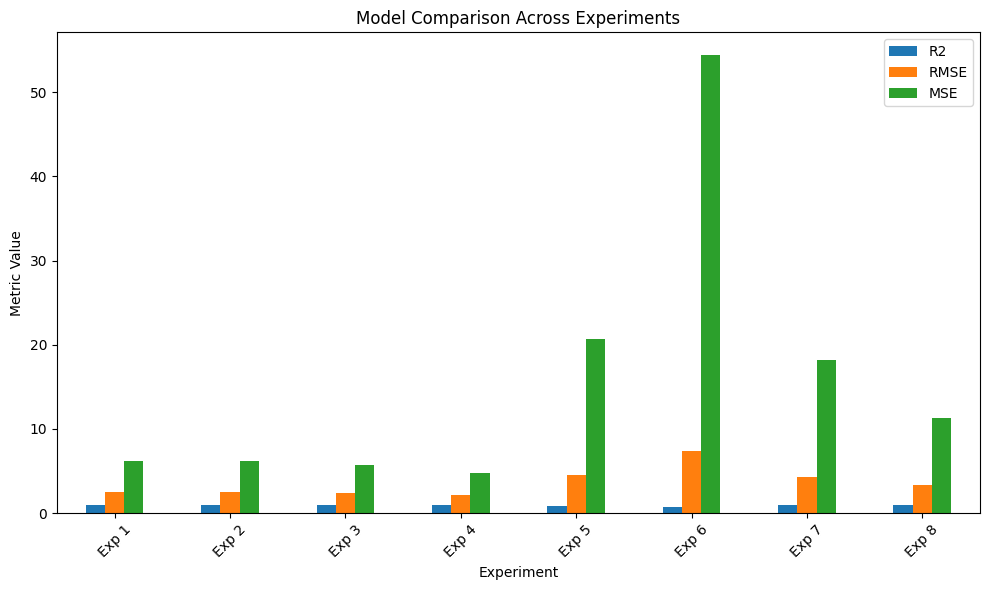

In [ ]:
import matplotlib.pyplot as plt

# Load results
results = pd.read_csv('/mnt/data/models/experiment_results.csv')

# Plot R², RMSE, and MSE per experiment
results.plot(
    x='Experiment',
    y=['R2', 'RMSE', 'MSE'],
    kind='bar',
    figsize=(10,6),
    title='Model Comparison Across Experiments'
)

plt.ylabel("Metric Value")
plt.xlabel("Experiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


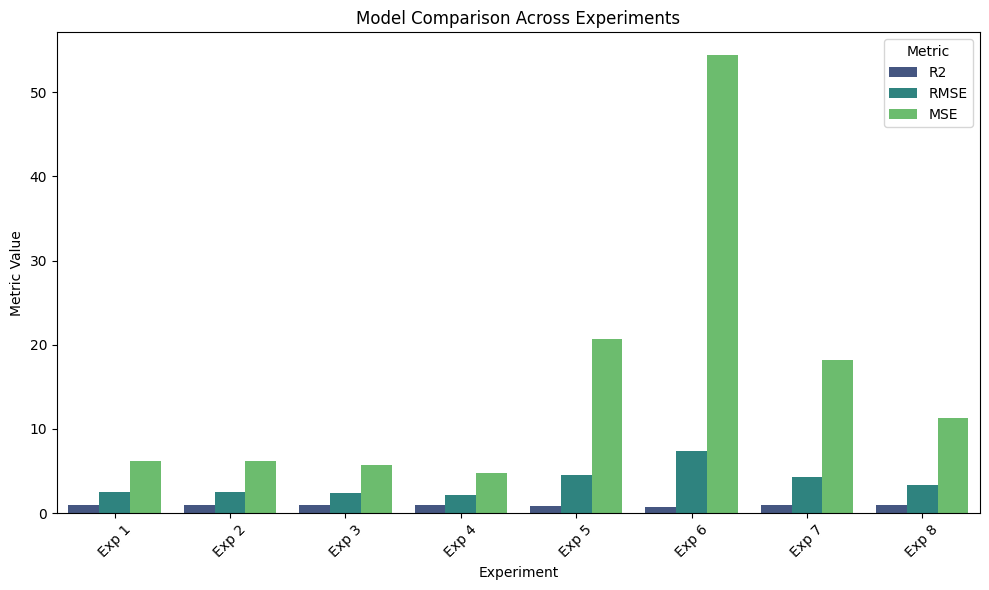

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results = pd.read_csv('/mnt/data/models/experiment_results.csv')

plt.figure(figsize=(10,6))
sns.barplot(
    data=results.melt(id_vars='Experiment', value_vars=['R2','RMSE','MSE']),
    x='Experiment', y='value', hue='variable', palette='viridis'
)
plt.title("Model Comparison Across Experiments")
plt.ylabel("Metric Value")
plt.xlabel("Experiment")
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [ ]:
print("Top models by R²:")
display(results.sort_values('R2', ascending=False).head(3))

print("Top models by lowest RMSE:")
display(results.sort_values('RMSE', ascending=True).head(3))

print("Top models by lowest MSE:")
display(results.sort_values('MSE', ascending=True).head(3))


Top models by R²:


,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth
2,Exp 3,RandomForest,"{'n_estimators': 200, 'max_depth': 12}",129801,27814,27815,5.713861,2.390368,0.972428,Tree ensemble captures nonlinearities
0,Exp 1,LinearRegression,{'fit_intercept': True},129801,27814,27815,6.243288,2.498657,0.969873,Baseline linear model on freq-encoded + numeri...


Top models by lowest RMSE:


,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth
2,Exp 3,RandomForest,"{'n_estimators': 200, 'max_depth': 12}",129801,27814,27815,5.713861,2.390368,0.972428,Tree ensemble captures nonlinearities
0,Exp 1,LinearRegression,{'fit_intercept': True},129801,27814,27815,6.243288,2.498657,0.969873,Baseline linear model on freq-encoded + numeri...


Top models by lowest MSE:


,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth
2,Exp 3,RandomForest,"{'n_estimators': 200, 'max_depth': 12}",129801,27814,27815,5.713861,2.390368,0.972428,Tree ensemble captures nonlinearities
0,Exp 1,LinearRegression,{'fit_intercept': True},129801,27814,27815,6.243288,2.498657,0.969873,Baseline linear model on freq-encoded + numeri...


In [ ]:
results['score'] = results['R2'] - 0.1*results['RMSE'] - 0.01*results['MSE']
best = results.sort_values('score', ascending=False).head(1)
print("🏆 Best overall model:")
display(best)


🏆 Best overall model:


,Experiment,Model,Hyperparams,TrainSamples,ValSamples,TestSamples,MSE,RMSE,R2,Notes,score
3,Exp 4,GradientBoosting,"{'n_estimators': 300, 'lr': 0.05, 'max_depth': 5}",129801,27814,27815,4.719041,2.172335,0.977229,Boosted trees with moderate depth,0.712805


/tmp/ipython-input-3081475384.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Experiment', y='R2', palette='crest')


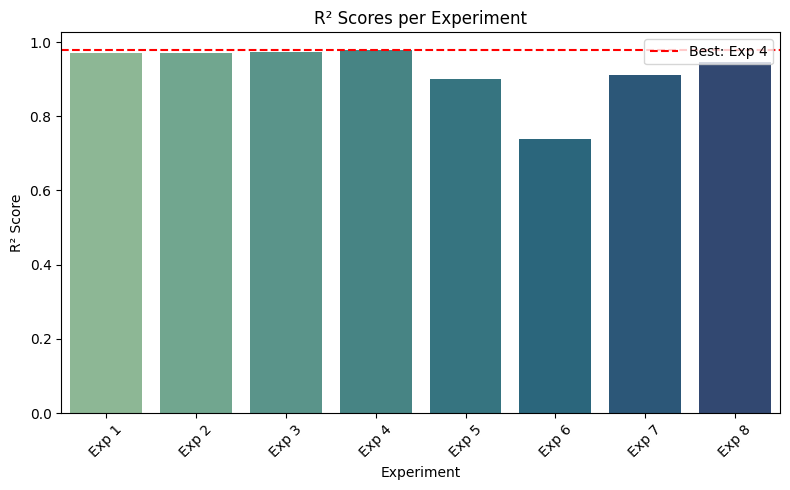

In [ ]:
best_model = results.loc[results['R2'].idxmax(), 'Experiment']

plt.figure(figsize=(8,5))
sns.barplot(data=results, x='Experiment', y='R2', palette='crest')
plt.title("R² Scores per Experiment")
plt.ylabel("R² Score")
plt.xlabel("Experiment")
plt.xticks(rotation=45)
plt.axhline(results['R2'].max(), color='red', linestyle='--', label=f'Best: {best_model}')
plt.legend()
plt.tight_layout()
plt.show()


**End...**